In [1]:
from sqlalchemy import create_engine, text
import pandas as pd
from ml_experiments.analyze import get_df_runs_from_mlflow_sql, get_missing_entries, get_common_combinations, get_df_with_combinations
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path

# Save Results

## Load mlflow runs

In [2]:
db_port = 5101
db_name = 'cohirf'
w = 'clust9'
# url = f'postgresql://{w}.ceremade.dauphine.lan:{db_port}/{db_name}'
url = f'postgresql://beluccib@localhost:{db_port}/{db_name}'
engine = create_engine(url)
query = 'SELECT experiments.name from experiments'
experiment_names = pd.read_sql(query, engine)['name'].tolist()
results_dir = Path('/home/bbelucci/code/recursive_clustering/results/processed_results')
results_dir.mkdir(parents=True, exist_ok=True)

In [3]:
experiment_names

['Default',
 'classif_huge_cohirf',
 'classif_huge_kmeans',
 'classif_clusters_kmeans',
 'classif_clusters_cohirf',
 'classif_huge_cohirf_sampling',
 'classif_huge_cohirf_minibatch',
 'time_hc_CompleteAgglomerativeClustering_samples',
 'time_hc_WardAgglomerativeClustering_samples',
 'time_hc_OPTICS_samples',
 'time_hc_CompleteAgglomerativeClustering_features',
 'time_hc_Proclus_features',
 'time_hc_WardAgglomerativeClustering_features',
 'time_hc_KMeans_features',
 'time_hc_KMeansProj_samples',
 'time_hc_Clique_samples',
 'time_hc_DBSCAN_features',
 'time_hc_KMeans_samples',
 'time_hc_DBSCAN_samples',
 'time_hc_AffinityPropagation_samples',
 'time_hc_RecursiveClustering_features',
 'time_hc_SpectralSubspaceRandomization_samples',
 'time_hc_KMeansProj_features',
 'time_hc_MeanShift_features',
 'time_hc_HDBSCAN_features',
 'time_hc_OPTICS_features',
 'time_hc_Clique_features',
 'time_hc_IRFLLRR_features',
 'time_hc_RecursiveClustering_samples',
 'time_hc_MeanShift_samples',
 'time_hc_Spe

In [4]:
experiments_names = [exp for exp in experiment_names if exp.find('gaussian')!=-1 and exp.find('gaussian_random')==-1]

In [5]:
params_columns = [
    'model_nickname',
    'n_samples',
    'n_features',
    'n_centers',
    'distance',
    'pct_random_features',
    'seed_unified',
    'hpo_metric',
]

In [6]:
latest_metrics_columns = [
    'fit_model_return_elapsed_time',
    'max_memory_used',
    'n_clusters_',
    'rand_score',
    'adjusted_rand',
    'mutual_info',
    'adjusted_mutual_info',
    'normalized_mutual_info',
    'homogeneity',
    'completeness',
    'v_measure',
    'silhouette',
    'calinski_harabasz_score',
    'davies_bouldin_score',
    'inertia_score',
    'best_n_clusters_',
    'best_rand_score',
    'best_adjusted_rand',
    'best_mutual_info',
    'best_adjusted_mutual_info',
    'best_normalized_mutual_info',
    'best_homogeneity_completeness_v_measure',
    'best_silhouette',
    'best_calinski_harabasz_score',
    'best_davies_bouldin_score',
    'best_inertia_score',
    'best_homogeneity',
    'best_completeness',
    'best_v_measure',
]

In [7]:
tags_columns = [
    'raised_exception',
    'EXCEPTION',
    'parent_run_id',
    'best_child_run_id',
]

In [8]:
runs_columns = ['run_uuid', 'status', 'start_time', 'end_time']
experiments_columns = []
other_table = 'params'
other_table_keys = params_columns
df_params = get_df_runs_from_mlflow_sql(engine, runs_columns=runs_columns, experiments_columns=experiments_columns, experiments_names=experiments_names, other_table=other_table, other_table_keys=other_table_keys)
df_latest_metrics = get_df_runs_from_mlflow_sql(engine, runs_columns=['run_uuid'], experiments_columns=experiments_columns, experiments_names=experiments_names, other_table='latest_metrics', other_table_keys=latest_metrics_columns)
df_tags = get_df_runs_from_mlflow_sql(engine, runs_columns=['run_uuid'], experiments_columns=experiments_columns, experiments_names=experiments_names, other_table='tags', other_table_keys=tags_columns)

In [9]:
df_runs_raw = df_params.join(df_latest_metrics)
df_runs_raw = df_runs_raw.join(df_tags)

In [10]:
df_runs_raw_parents = df_runs_raw.copy()
df_runs_raw_parents = df_runs_raw_parents.loc[df_runs_raw_parents['parent_run_id'].isna()]

In [11]:
df_runs_raw_parents

key,status,start_time,end_time,distance,hpo_metric,model_nickname,n_centers,n_features,n_samples,pct_random_features,...,mutual_info,n_clusters_,normalized_mutual_info,rand_score,silhouette,v_measure,EXCEPTION,best_child_run_id,parent_run_id,raised_exception
run_uuid,,,,,,,,,,,,,,,,,,,,,
00192c6c15f542b9868bd8d379682695,RUNNING,1742936793427,NaN,30.0,calinski_harabasz_score,WardAgglomerativeClustering,5,1000,10000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
002781b9c334421ea3478bd2da0ef523,RUNNING,1742933964325,NaN,30.0,calinski_harabasz_score,Proclus,5,100,10000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00279e89ccab4c4a9c94ed297b29f7aa,FAILED,1743228826290,1.743236e+12,70.0,silhouette,KMeansProj,5,10000,1000,None,...,NaN,NaN,NaN,NaN,NaN,NaN,"Every trial failed, no best model was found",NaN,NaN,True
004998a8de1f45969ed13cee9d6e6b60,FINISHED,1742922310260,1.742922e+12,10.0,silhouette,KMeans,5,100,100,NaN,...,1.609438,14.0,0.803130,0.907495,0.035456,0.803130,NaN,3515273555b3494c8e2d8b844d2ea9c8,NaN,False
006b2ec98f0a4e4289d3c3844aa857db,FAILED,1742944965136,1.742950e+12,10.0,silhouette,HDBSCAN,5,1000,10000,None,...,NaN,NaN,NaN,NaN,NaN,NaN,"Every trial failed, no best model was found",NaN,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffb5365ac06843339df76e553d8bfd78,FINISHED,1742921882414,1.742922e+12,30.0,silhouette,CompleteAgglomerativeClustering,5,10000,100,NaN,...,1.609438,14.0,0.810917,0.909467,0.001154,0.810917,NaN,d6c7b3ae83ea41e0979c6e78f4f0b174,NaN,False
ffd0beb35f5e46a39d2bcebbb87ad148,RUNNING,1742924258161,NaN,30.0,calinski_harabasz_score,IRFLLRR,5,1000,1000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fff203875c4f4c4eaae0d69a9dd3910d,RUNNING,1742927123511,NaN,10.0,silhouette,DBSCAN,5,1000,10000,NaN,...,0.000000,1.0,0.000000,0.199984,-1.000000,0.000000,NaN,NaN,NaN,NaN


## Delete duplicate runs (if any) and complete some models that cannot run with some datasets

In [12]:
non_duplicate_columns = [
    'model_nickname',
    'n_samples',
    'n_features',
    'n_centers',
    'distance',
    'seed_unified',
    'hpo_metric',
    'pct_random_features',
]
df_runs_parents = df_runs_raw_parents.dropna(axis=0, how='all', subset=['best_adjusted_rand']).copy()
df_runs_parents = df_runs_parents.loc[(~df_runs_parents.duplicated(non_duplicate_columns))]

# Missing

In [13]:
model_nickname = df_runs_parents['model_nickname'].unique().tolist()
model_nickname.sort()
model_nickname

['AffinityPropagation',
 'AverageAgglomerativeClustering',
 'Clique',
 'CompleteAgglomerativeClustering',
 'DBSCAN',
 'HDBSCAN',
 'IRFLLRR',
 'KMeans',
 'KMeansProj',
 'MeanShift',
 'OPTICS',
 'Proclus',
 'RecursiveClustering',
 'RecursiveClusteringHDBSCAN',
 'RecursiveClusteringSCSRGF',
 'RecursiveClustering_full',
 'SingleAgglomerativeClustering',
 'SpectralClustering',
 'SpectralSubspaceRandomization',
 'WardAgglomerativeClustering']

In [14]:
non_duplicate_columns = [
    'model_nickname',
    'n_samples',
    'n_features',
    'distance',
    'n_centers',
    'seed_unified',
    'hpo_metric',
]

In [15]:
n_samples = ['100', '1000', '10000']
n_features = ['100']
distances = ['3.0', '10.0', '30.0']
n_centers = ['5']
seed_unified = [f'{i}' for i in range(5)]
model_nickname = [
    'AffinityPropagation',
    'AverageAgglomerativeClustering',
    'Clique',
    'CompleteAgglomerativeClustering',
    'DBSCAN',
    'HDBSCAN',
    'IRFLLRR',
    'KMeans',
    'KMeansProj',
    'MeanShift',
    'OPTICS',
    'Proclus',
    'RecursiveClustering',
    'SingleAgglomerativeClustering',
    'SpectralClustering',
    'SpectralSubspaceRandomization',
    'WardAgglomerativeClustering'
]
hpo_metric = ['silhouette', 'calinski_harabasz_score']
columns_names = non_duplicate_columns
should_contain_values = [model_nickname, n_samples, n_features, distances, n_centers, seed_unified, hpo_metric]
df_missing = get_missing_entries(df_runs_parents, columns_names, should_contain_values)

In [16]:
df_missing

,model_nickname,n_samples,n_features,distance,n_centers,seed_unified,hpo_metric
0,AffinityPropagation,10000,100,3.0,5,0,silhouette
1,AffinityPropagation,10000,100,3.0,5,0,calinski_harabasz_score
2,AffinityPropagation,10000,100,3.0,5,1,silhouette
3,AffinityPropagation,10000,100,3.0,5,1,calinski_harabasz_score
4,AffinityPropagation,10000,100,3.0,5,2,silhouette
...,...,...,...,...,...,...,...
870,WardAgglomerativeClustering,10000,100,30.0,5,2,calinski_harabasz_score
871,WardAgglomerativeClustering,10000,100,30.0,5,3,silhouette
872,WardAgglomerativeClustering,10000,100,30.0,5,3,calinski_harabasz_score
873,WardAgglomerativeClustering,10000,100,30.0,5,4,silhouette


In [17]:
n_samples = ['100', '1000', '10000']
n_features = ['1000']
distances = ['10.0', '30.0', '100.0']
n_centers = ['5']
seed_unified = [f'{i}' for i in range(5)]
model_nickname = [
    'AffinityPropagation',
    'AverageAgglomerativeClustering',
    'Clique',
    'CompleteAgglomerativeClustering',
    'DBSCAN',
    'HDBSCAN',
    'IRFLLRR',
    'KMeans',
    'KMeansProj',
    'MeanShift',
    'OPTICS',
    'Proclus',
    'RecursiveClustering',
    'SingleAgglomerativeClustering',
    'SpectralClustering',
    'SpectralSubspaceRandomization',
    'WardAgglomerativeClustering'
]
hpo_metric = ['silhouette', 'calinski_harabasz_score']
columns_names = non_duplicate_columns
should_contain_values = [model_nickname, n_samples, n_features, distances, n_centers, seed_unified, hpo_metric]
df_missing = get_missing_entries(df_runs_parents, columns_names, should_contain_values)

In [18]:
df_missing

,model_nickname,n_samples,n_features,distance,n_centers,seed_unified,hpo_metric
0,AffinityPropagation,10000,1000,10.0,5,0,silhouette
1,AffinityPropagation,10000,1000,10.0,5,0,calinski_harabasz_score
2,AffinityPropagation,10000,1000,10.0,5,1,silhouette
3,AffinityPropagation,10000,1000,10.0,5,1,calinski_harabasz_score
4,AffinityPropagation,10000,1000,10.0,5,2,silhouette
...,...,...,...,...,...,...,...
794,WardAgglomerativeClustering,10000,1000,100.0,5,2,calinski_harabasz_score
795,WardAgglomerativeClustering,10000,1000,100.0,5,3,silhouette
796,WardAgglomerativeClustering,10000,1000,100.0,5,3,calinski_harabasz_score
797,WardAgglomerativeClustering,10000,1000,100.0,5,4,silhouette


In [19]:
n_samples = ['100', '1000', '10000']
n_features = ['10000']
distances = ['30.0', '100.0', '300.0']
n_centers = ['5']
seed_unified = [f'{i}' for i in range(5)]
model_nickname = [
    'AffinityPropagation',
    'AverageAgglomerativeClustering',
    'Clique',
    'CompleteAgglomerativeClustering',
    'DBSCAN',
    'HDBSCAN',
    'IRFLLRR',
    'KMeans',
    'KMeansProj',
    'MeanShift',
    'OPTICS',
    'Proclus',
    'RecursiveClustering',
    'SingleAgglomerativeClustering',
    'SpectralClustering',
    'SpectralSubspaceRandomization',
    'WardAgglomerativeClustering'
]
hpo_metric = ['silhouette', 'calinski_harabasz_score']
columns_names = non_duplicate_columns
should_contain_values = [model_nickname, n_samples, n_features, distances, n_centers, seed_unified, hpo_metric]
df_missing = get_missing_entries(df_runs_parents, columns_names, should_contain_values)

In [20]:
df_missing

,model_nickname,n_samples,n_features,distance,n_centers,seed_unified,hpo_metric
0,AffinityPropagation,100,10000,30.0,5,1,silhouette
1,AffinityPropagation,100,10000,30.0,5,2,silhouette
2,AffinityPropagation,100,10000,30.0,5,3,silhouette
3,AffinityPropagation,100,10000,30.0,5,3,calinski_harabasz_score
4,AffinityPropagation,100,10000,30.0,5,4,silhouette
...,...,...,...,...,...,...,...
915,WardAgglomerativeClustering,10000,10000,300.0,5,2,calinski_harabasz_score
916,WardAgglomerativeClustering,10000,10000,300.0,5,3,silhouette
917,WardAgglomerativeClustering,10000,10000,300.0,5,3,calinski_harabasz_score
918,WardAgglomerativeClustering,10000,10000,300.0,5,4,silhouette


In [21]:
n_samples = ['1000']
n_features = ['10000']
distances = ['70.0', '80.0','100.0','150.0','200.0']
n_centers = ['5']
seed_unified = [f'{i}' for i in range(5)]
model_nickname = [
    'AffinityPropagation',
    'AverageAgglomerativeClustering',
    'Clique',
    'CompleteAgglomerativeClustering',
    'DBSCAN',
    'HDBSCAN',
    'IRFLLRR',
    'KMeans',
    'KMeansProj',
    'MeanShift',
    'OPTICS',
    'Proclus',
    'RecursiveClustering',
    'SingleAgglomerativeClustering',
    'SpectralClustering',
    'SpectralSubspaceRandomization',
    'WardAgglomerativeClustering'
]
hpo_metric = ['silhouette']
columns_names = non_duplicate_columns
should_contain_values = [model_nickname, n_samples, n_features, distances, n_centers, seed_unified, hpo_metric]
df_missing = get_missing_entries(df_runs_parents, columns_names, should_contain_values)

In [22]:
df_missing

,model_nickname,n_samples,n_features,distance,n_centers,seed_unified,hpo_metric
0,IRFLLRR,1000,10000,70.0,5,0,silhouette
1,IRFLLRR,1000,10000,70.0,5,1,silhouette
2,IRFLLRR,1000,10000,70.0,5,2,silhouette
3,IRFLLRR,1000,10000,70.0,5,3,silhouette
4,IRFLLRR,1000,10000,70.0,5,4,silhouette
...,...,...,...,...,...,...,...
118,SpectralSubspaceRandomization,1000,10000,200.0,5,0,silhouette
119,SpectralSubspaceRandomization,1000,10000,200.0,5,1,silhouette
120,SpectralSubspaceRandomization,1000,10000,200.0,5,2,silhouette
121,SpectralSubspaceRandomization,1000,10000,200.0,5,3,silhouette


In [23]:
139

139

In [23]:
# df = df_runs_raw.copy()
# df = df.loc[df['model_nickname'] == 'RecursiveClustering']
# df = df.loc[df['n_samples'] == '10000']
# df = df.loc[df['n_features'] == '1000']
# df = df.loc[df['n_centers'] == '5']
# df = df.loc[df['hpo_metric'] == 'calinski_harabasz_score']
# df = df.loc[df['pct_random_features'] == '0.7']
# df = df.loc[df['distance'] == '10.0']
# df

key,status,start_time,end_time,distance,hpo_metric,model_nickname,n_centers,n_features,n_samples,pct_random_features,...,mutual_info,n_clusters_,normalized_mutual_info,rand_score,silhouette,v_measure,EXCEPTION,best_child_run_id,parent_run_id,raised_exception
run_uuid,,,,,,,,,,,,,,,,,,,,,


# Get common combinations

In [23]:
model_nickname = [
    'AffinityPropagation',
    'AverageAgglomerativeClustering',
    'Clique',
    'CompleteAgglomerativeClustering',
    'DBSCAN',
    'HDBSCAN',
    # 'IRFLLRR',
    'KMeans',
    # 'KMeansProj',
    # 'MeanShift',
    'OPTICS',
    'Proclus',
    'RecursiveClustering',
    'SingleAgglomerativeClustering',
    # 'SpectralClustering',
    # 'SpectralSubspaceRandomization',
    'WardAgglomerativeClustering'
]
df = df_runs_parents.copy()
df = df.loc[df['model_nickname'].isin(model_nickname)]
column = 'model_nickname'
combination_columns = [
    'n_samples',
    'n_features',
    'distance',
    'n_centers',
    'seed_unified',
    'hpo_metric',
    'pct_random_features',
]
common_combinations = get_common_combinations(df, column, combination_columns)

In [24]:
df_common = get_df_with_combinations(df, combination_columns, common_combinations)

In [25]:
df_common['n_samples'] = df_common['n_samples'].astype(int)
df_common['n_features'] = df_common['n_features'].astype(int)
df_common['distance'] = df_common['distance'].astype(float)
df_common['n_centers'] = df_common['n_centers'].astype(float)
df_common['seed_unified'] = df_common['seed_unified'].astype(int)
# df_common = df_common.loc[df_common['pct_random_features'] != 'None']
# df_common['pct_random_features'] = df_common['pct_random_features'].astype(float)

In [26]:
df_common

key,status,start_time,end_time,distance,hpo_metric,model_nickname,n_centers,n_features,n_samples,pct_random_features,...,mutual_info,n_clusters_,normalized_mutual_info,rand_score,silhouette,v_measure,EXCEPTION,best_child_run_id,parent_run_id,raised_exception
run_uuid,,,,,,,,,,,,,,,,,,,,,
010954f35d7c4e78ac37b10b607f1943,FINISHED,1743229805671,1.743231e+12,150.0,silhouette,AffinityPropagation,5.0,10000,1000,None,...,1.609438,16.0,0.757959,0.885891,0.065374,0.757959,NaN,8782d2faee544df9ab14afd50e1a2886,NaN,False
0110f36c9cd44688a77aebd6f8eb6f50,FINISHED,1743068297437,1.743070e+12,30.0,silhouette,RecursiveClustering,5.0,10000,1000,None,...,0.695835,693.0,0.178294,0.799444,-0.020906,0.178294,NaN,fd1c7dd1dd9d433e9240261acb53eb40,NaN,False
019b92b712d44af49a413d119117f59f,FINISHED,1743228842104,1.743230e+12,80.0,silhouette,Proclus,5.0,10000,1000,None,...,0.016163,4.0,0.011077,0.631768,-0.003508,0.011077,NaN,1af35feeeb1e4d56923b2e0ba851c034,NaN,False
019eeba88a2a4501b3ac35cd43fccbad,FINISHED,1742901029664,1.742901e+12,30.0,calinski_harabasz_score,WardAgglomerativeClustering,5.0,10000,100,NaN,...,1.609438,14.0,0.778971,0.889539,0.000971,0.778971,NaN,3fa2bbd6ca8a4983a9a3e4d758f67480,NaN,False
01b3ce83e0d7456b8d0bd7ce1f08ba5b,FINISHED,1743074234276,1.743075e+12,70.0,silhouette,RecursiveClustering,5.0,10000,1000,None,...,1.133602,22.0,0.641283,0.841647,-0.032291,0.641283,NaN,46a15bf80f5b441bba6a4cecfd4edfa3,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fd7c948db7074587bc1a870d46f5137c,FINISHED,1743302894980,1.743304e+12,80.0,silhouette,WardAgglomerativeClustering,5.0,10000,1000,None,...,1.609438,14.0,0.773194,0.882570,-0.000006,0.773194,NaN,fbb8664626c24f6dbed759f6d903d35e,NaN,False
ff036df7c7404d618ea56e303d832a90,FINISHED,1743230203804,1.743230e+12,200.0,silhouette,RecursiveClustering,5.0,10000,1000,None,...,1.609438,5.0,1.000000,1.000000,0.421425,1.000000,NaN,00afea1732364b8db33b4307a000d7d2,NaN,False
ff179f7d32cb4550b9616b8ca5f2d454,FINISHED,1743069430603,1.743070e+12,70.0,silhouette,DBSCAN,5.0,10000,1000,None,...,0.000000,1.0,0.000000,0.199840,-1.000000,0.000000,NaN,0f1f19659b0747319eaf9ff910193987,NaN,False


# Plots

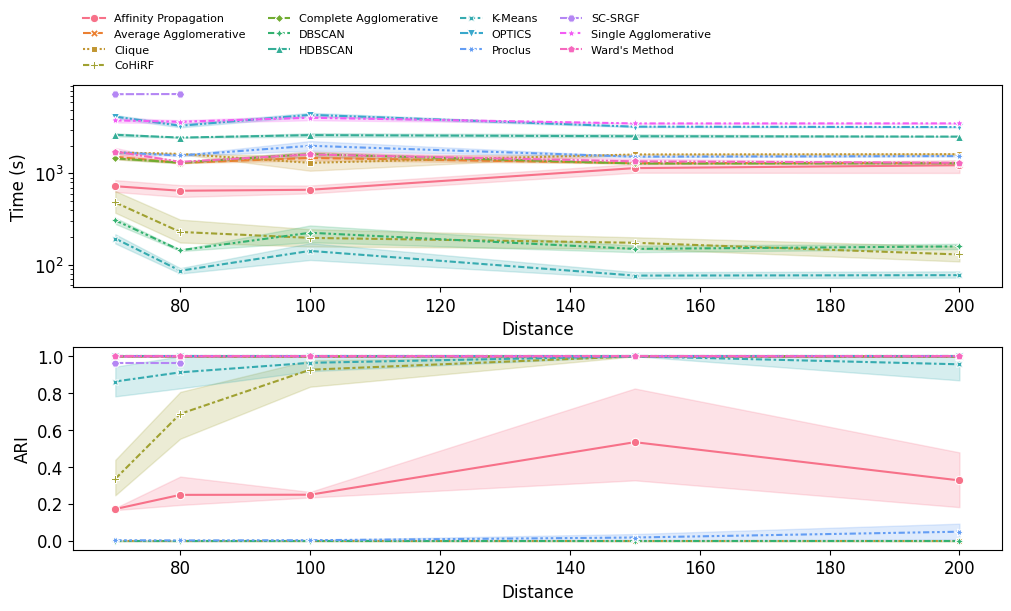

In [26]:
df = df_runs_parents.copy()
n_features = 10000
n_samples = 1000
pct_random_features = 0.0
distance = 30
hpo_metric = 'silhouette'

models_names = {
    'AffinityPropagation': 'Affinity Propagation',
    'AverageAgglomerativeClustering': 'Average Agglomerative',
    'Clique': 'Clique',
    'CompleteAgglomerativeClustering': 'Complete Agglomerative',
    'DBSCAN': 'DBSCAN',
    'HDBSCAN': 'HDBSCAN',
    'IRFLLRR': 'IRFLLRR',
    'KMeans': 'K-Means',
    'KMeansProj': 'Projective K-Means',
    'MeanShift': 'Mean Shift',
    'OPTICS': 'OPTICS',
    'Proclus': 'Proclus',
    'RecursiveClustering': 'CoHiRF',
    # 'RecursiveClusteringHDBSCAN': 'CoHiRF HDBSCAN',
    # 'RecursiveClusteringSCSRGF': 'CoHiRF SC-SRGF',
    # 'RecursiveClustering_full': 'CoHiRF Full',
    'SingleAgglomerativeClustering': 'Single Agglomerative',
    'SpectralClustering': 'Spectral Clustering',
    'SpectralSubspaceRandomization': 'SC-SRGF',
    'WardAgglomerativeClustering': "Ward's Method",
}
df['n_samples'] = df['n_samples'].astype(int)
df['n_features'] = df['n_features'].astype(int)
df['distance'] = df['distance'].astype(float)
df = df.loc[df['hpo_metric']==hpo_metric]
# df = df.loc[df['pct_random_features']==pct_random_features]
df = df.loc[df['distance'].isin([70,80,100,150,200])]
# df = df.loc[~df['class_sep'].isin([10, 20])]
df = df.loc[df['model_nickname'].isin(models_names.keys())]
df = df.replace({'model_nickname': models_names})
df = df.sort_values(by='model_nickname')
df = df.rename(columns={'fit_model_return_elapsed_time': 'Time (s)', 'max_memory_used': 'Memory (MB)', 'n_samples': 'Number of samples', 'n_features': 'Number of features', 'model_nickname': 'Model', 'distance': 'Distance', 'pct_random_features': '% Random Features', 'best_adjusted_rand' : 'ARI'})
plt.style.use('default')
with mpl.rc_context(rc={
    'figure.constrained_layout.use': True,
    'savefig.bbox': 'tight',
    'figure.figsize': (10, 6),
    'legend.loc': 'upper left',
    'legend.frameon': False,
    'font.size': 12,
    # 'font.family': 'serif',
    # 'font.serif': 'Times',
    'text.color': 'black',
    'grid.color': 'black',
    'grid.alpha': 0.5,
}):
    fig, axs = plt.subplots(2, 1)
    axs = axs.flatten()
    df_plot = df.copy()
    df_plot = df_plot.loc[df_plot['Number of features']==n_features]
    df_plot = df_plot.loc[df_plot['Number of samples']==n_samples]
    ax = sns.lineplot(data=df_plot, x='Distance', y='Time (s)', hue='Model', style='Model', markers=True, errorbar='ci', ax=axs[0])
    ax.legend().set_visible(False)
    ax.set_yscale('log')
    ax2 = sns.lineplot(data=df_plot, x='Distance', y='ARI', hue='Model', style='Model', markers=True, errorbar='ci', ax=axs[1])
    ax2.legend().set_visible(False)
    ax.legend(title=None, fontsize=8, bbox_to_anchor=(0.0, 1.4), ncols=4)
    plt.savefig(results_dir / f'gaussian_n-samples{n_samples}_n-features{n_features}_with_time.pdf')
    plt.show()

/tmp/ipykernel_181876/4057250424.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend().set_visible(False)
/tmp/ipykernel_181876/4057250424.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend().set_visible(False)
/tmp/ipykernel_181876/4057250424.py:40: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title=None, fontsize=12, bbox_to_anchor=(0.0, 1.3), ncols=4)


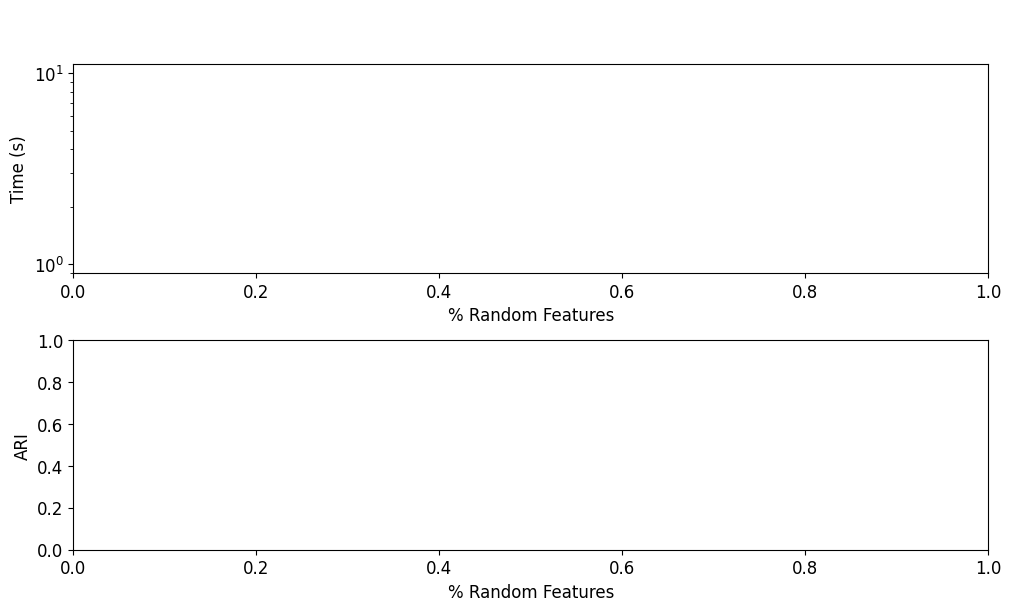

In [47]:
df = df_common.copy()
n_features = 1000
n_samples = 1000
pct_random_features = 0.1
distance = 30
models_names = {
    'RecursiveClustering': 'CoHiRF',
}
# df = df.loc[df['pct_random_features']==pct_random_features]
df = df.loc[df['distance']==distance]
# df = df.loc[~df['class_sep'].isin([10, 20])]
# df = df.loc[df['model_nickname'].isin(['RecursiveClustering_20', 'KMeans', 'HDBSCAN', 'AffinityPropagation', 'OPTICS', 'SpectralSubspaceRandomization', 'WardAgglomerativeClustering'])]
df = df.replace({'model_nickname': models_names})
df = df.sort_values(by='model_nickname')
df = df.rename(columns={'fit_model_return_elapsed_time': 'Time (s)', 'max_memory_used': 'Memory (MB)', 'n_samples': 'Number of samples', 'n_features': 'Number of features', 'model_nickname': 'Model', 'distance': 'Distance', 'pct_random_features': '% Random Features', 'best_adjusted_rand' : 'ARI'})
plt.style.use('default')
with mpl.rc_context(rc={
    'figure.constrained_layout.use': True,
    'savefig.bbox': 'tight',
    'figure.figsize': (10, 6),
    'legend.loc': 'upper left',
    'legend.frameon': False,
    'font.size': 12,
    # 'font.family': 'serif',
    # 'font.serif': 'Times',
    'text.color': 'black',
    'grid.color': 'black',
    'grid.alpha': 0.5,
}):
    fig, axs = plt.subplots(2, 1)
    axs = axs.flatten()
    df_plot = df.copy()
    df_plot = df_plot.loc[df_plot['Number of features']==n_features]
    df_plot = df_plot.loc[df_plot['Number of samples']==n_samples]
    ax = sns.lineplot(data=df_plot, x='% Random Features', y='Time (s)', hue='Model', style='Model', markers=True, errorbar='ci', ax=axs[0])
    ax.legend().set_visible(False)
    ax.set_yscale('log')
    ax2 = sns.lineplot(data=df_plot, x='% Random Features', y='ARI', hue='Model', style='Model', markers=True, errorbar='ci', ax=axs[1])
    ax2.legend().set_visible(False)
    ax.legend(title=None, fontsize=12, bbox_to_anchor=(0.0, 1.3), ncols=4)
    # plt.savefig(results_dir / f'hypercube_n-samples{n_samples}_n-features{n_features}_pct-random{pct_random}_with_time.pdf')
    plt.show()

In [54]:
df

key,status,start_time,end_time,Distance,hpo_metric,Model,n_centers,Number of features,Number of samples,% Random Features,...,mutual_info,n_clusters_,normalized_mutual_info,rand_score,silhouette,v_measure,EXCEPTION,best_child_run_id,parent_run_id,raised_exception
run_uuid,,,,,,,,,,,,,,,,,,,,,
464daa4b96674ff38bcf4dfff56c72be,FINISHED,1742926917920,1.742928e+12,3.0,calinski_harabasz_score,AffinityPropagation,5,100,1000,NaN,...,0.285417,153.0,0.088772,0.795200,-0.064017,0.088772,NaN,4d867209cc9845de96789ec9f66034ce,NaN,False
ea48a54d64d94a7fa1c697fdbefd04f0,FINISHED,1742927042066,1.742928e+12,10.0,calinski_harabasz_score,AffinityPropagation,5,1000,1000,NaN,...,1.307967,163.0,0.399158,0.805781,-0.023710,0.399158,NaN,7dd4636801034b6d9f5b20ca37422359,NaN,False
9d136b2028554ea889ec757e9f231956,FINISHED,1742925840603,1.742927e+12,10.0,silhouette,AffinityPropagation,5,1000,1000,NaN,...,1.281899,161.0,0.391577,0.805489,-0.018743,0.391577,NaN,df8400fedc5a4e3d988ce60b4ab80fb8,NaN,False
9e09f8c2248c4bd3af32c04effec1072,FINISHED,1742928254648,1.742929e+12,3.0,calinski_harabasz_score,AffinityPropagation,5,100,1000,NaN,...,0.268737,141.0,0.084358,0.795381,-0.052850,0.084358,NaN,d1426b6467ef43cda85611f68a6f77bf,NaN,False
6d3ef443f8234a91a46ecc454cd8e2ee,FINISHED,1742933517552,1.742934e+12,30.0,calinski_harabasz_score,AffinityPropagation,5,100,1000,NaN,...,1.609438,36.0,0.625976,0.831223,-0.003382,0.625976,NaN,92dc0407bb8f405b811ab285c4314e89,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b6576c18f4bd427ca0992d3b1fccb5eb,FINISHED,1742927597034,1.742928e+12,100.0,calinski_harabasz_score,WardAgglomerativeClustering,5,1000,1000,NaN,...,1.609438,14.0,0.774886,0.884187,-0.000416,0.774886,NaN,d02e2e018e0b45f6a7d41c2d382a4450,NaN,False
23cc11a5f47d40bfb24c45ccbde09028,FINISHED,1742925298819,1.742925e+12,10.0,silhouette,WardAgglomerativeClustering,5,100,1000,NaN,...,1.608024,14.0,0.772567,0.882868,0.001736,0.772567,NaN,e49d663dc46d4826a52a78572eca3a3b,NaN,False
264ef0a2ff97470081fe55eba1df33cc,FINISHED,1742923470919,1.742924e+12,300.0,silhouette,WardAgglomerativeClustering,5,10000,100,NaN,...,1.609438,14.0,0.770983,0.881507,0.001027,0.770983,NaN,e3aa6555b0e6479fb14c6badba34a6c1,NaN,False


# Debug and explore

In [61]:
df = df_runs_raw_parents.copy()
df = df.loc[df['model_nickname'] == 'SpectralClustering']
df = df.loc[df['n_samples'] == '10000']
df = df.loc[df['n_features'] == '100']
df = df.loc[df['best_adjusted_rand'].isna()]

In [62]:
df

key,status,start_time,end_time,class_sep,model_nickname,n_classes,n_features,n_informative,n_random,n_samples,...,max_memory_used,mutual_info,n_clusters_,normalized_mutual_info,rand_score,silhouette,EXCEPTION,best_child_run_id,parent_run_id,raised_exception
run_uuid,,,,,,,,,,,,,,,,,,,,,
030506f367eb4de3ba20854815b5204e,RUNNING,1736933684597,NaN,50.0,SpectralClustering,5,100,2,16,10000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0a9621d4c0b94f71b8b3381c6fb5c007,RUNNING,1736933682412,NaN,50.0,SpectralClustering,5,100,2,16,10000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4283d0ec6c2a44609380a30ba9ad84b7,RUNNING,1736933676990,NaN,100.0,SpectralClustering,5,100,2,16,10000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86f54c66e3a24ae3abd719993b9e8e8f,RUNNING,1736933680295,NaN,10.0,SpectralClustering,5,100,2,16,10000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
d40e99f19313471b849c6a89d5714ec3,RUNNING,1736933677012,NaN,10.0,SpectralClustering,5,100,2,16,10000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f2472d2177ee4224888a3f9221aa27f8,RUNNING,1736933676833,NaN,100.0,SpectralClustering,5,100,2,16,10000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
parent_run_ids = list(df.index)

In [39]:
parent_run_ids

['19a02df7b5aa4cf7afa3bd89746701e6',
 '49cd3a57c8c445888338d601be88e165',
 '4ca1b086e9d54eb69b43c9d2a9f61751',
 '8ebecbdcf2534dbdb37fab56eb920877',
 'bc25dc49e69644d9b4ea7d47831c0db5',
 'c08e53cf4d534e67904e72ae35794d0e']

In [40]:
df = df_runs_raw.copy()
df = df.loc[df['parent_run_id'].isin(parent_run_ids)]

In [41]:
child_run_ids = list(df.index)

In [42]:
runs_to_delete = parent_run_ids + child_run_ids

In [43]:
runs_to_delete

['19a02df7b5aa4cf7afa3bd89746701e6',
 '49cd3a57c8c445888338d601be88e165',
 '4ca1b086e9d54eb69b43c9d2a9f61751',
 '8ebecbdcf2534dbdb37fab56eb920877',
 'bc25dc49e69644d9b4ea7d47831c0db5',
 'c08e53cf4d534e67904e72ae35794d0e',
 '1d4c759e165b4267af1d71e2dadb662e',
 '4731af3b49f94df79ed9c06cb61e5da9',
 '667f300899fe4b998d839e3958dedbd0',
 '8f9e6a95c8bd4f838fcb3085a3927482',
 'c7b04bdc92654f8da5f28f7a0474de79',
 'e97b7dd9f4c94acb95ad1b389c91aa3d']

In [44]:
run_uuid_query = [f"'{run_id}'" for run_id in runs_to_delete]
run_uuid_query = ', '.join(run_uuid_query)

In [45]:
query = f"""
UPDATE runs
SET lifecycle_stage = 'deleted'
WHERE run_uuid IN ({run_uuid_query}) 
"""
with engine.begin() as conn:
    conn.execute(text(query))

for i, row in df_runs_raw.iterrows():
    run_id = row.run_id
    model_name = row['params.model_name']
    with mlflow.start_run(run_id) as run:
        mlflow.log_param('model_nickname', model_name)    